# Binding Energy between proton and neutron in the Deuteron nucleus

At the current stage of quantum computing the quantum processors we have available do not yet have error correcting codes implemented and thus still have noise that must be contended with. This noise can adversely impact the results and hence can limit the sort of problems we can currently tackle when, due to the noise, a high level of confidence and precision cannot
be expected from the results.

However, there are some problems which demand only few qubits to be solved, like the computation of the binding energy between the proton and neutron in the Deuteron nucleus [[1]](https://arxiv.org/pdf/1801.03897.pdf). This problem is an example of a scenario where we can achieve good results despite the challenges mentioned earlier.

## Step 1: Importing the packages that we need to tackle the problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.observables_evaluator import estimate_observables
from qiskit.algorithms.optimizers import COBYLA, SLSQP
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter

## Step 2: Defining some functions that we will use

Before we start the definition of the Deuteron Hamiltonian, we need to define a utility function implementing the Kronecker delta, which is defined as follows:

$\delta_{n,m} = \bigg\{\begin{array}{c}0, \ \textrm{if} \ n \neq m \\1, \ \textrm{if } \ n = m.\end{array}$.

This function appears in the Deuteron Hamiltonian definition given in [[1]](https://arxiv.org/pdf/1801.03897.pdf). Below we have a piece of code that defines the Kronecker delta function.

In [2]:
def kronecker_delta_function(n: int, m: int) -> int:
    """An implementation of the Kronecker delta function.

    Args:
        n (int): The first integer argument.
        m (int): The second integer argument.

    Returns:
        Returns 1 if n = m, else returns 0.
    """
    return int(n == m)

In [[1]](https://arxiv.org/pdf/1801.03897.pdf) we can find the following expression for the Deuteron Hamiltonian
$H_N = \sum_{n,m=0}^{N-1}\langle m|(T+V)|n\rangle a_{m}^\dagger a_n$,
where $|n\rangle$ and $|m\rangle$ represent quantum states in the harmonic oscillator basis, and $a_m^\dagger$ and $a_n$ represent the creation and annihilation operators, respectively.

To create the code that defines $H_N$, we need the matrix elements of the kinetic and potential energy. Again, we find these expressions in [[1]](https://arxiv.org/pdf/1801.03897.pdf):

$\langle m|T|n\rangle = \frac{\hbar\omega}{2}\left[\left(2n+\frac{3}{2}\right)\delta_{n,m}-\sqrt{n(n+\frac{1}{2})}\delta_{n,m+1}-\sqrt{(n+1)(n+\frac{3}{2})}\delta_{n,m-1}\right],$
$\langle m|V|n\rangle = V_0\delta_{n,0}\delta_{n,m}.$

Where $V_0 = -5.68658111 \ \textrm{MeV}$ and $\hbar\omega = 7 \ \textrm{MeV}$. However, the Hamiltonian written in this way cannot be processed directly in a quantum computer, because a quantum computer manipulates qubits through gates based on Pauli matrices. Thus, we need to convert the creation and annihilation operators into Pauli operators. To do that, we can make use of the Jordan-Wigner transformation

$a_n^\dagger \ \rightarrow \ \frac{1}{2}\left[\prod_{j=0}^{n-1}-Z_j\right](X_n-iY_n),$

$a_n \ \rightarrow \ \frac{1}{2}\left[\prod_{j=0}^{n-1}-Z_j\right](X_n+iY_n).$

Fortunately, in Qiskit Nature we have tools to define fermionic operators and to convert this kind of operators into Pauli operators through the Jordan-Wigner transformation. Initially, we use a for loop to construct and store the labels and coefficients in a tuple, and after this, we add the tuple in a list. Each string label and coefficient define a kinetic element $\langle m|T|n\rangle$ and a potential element $\langle m|V|n\rangle$ of the Hamiltonian. At the end of the for loop, we have to pass the list with the tuples with labels and coefficients to `FermionicOp`, in order to create a Hamiltonian in terms of the creation and annihilation operators. We need to rewrite this Hamiltonian in terms of Pauli operators, to do this we use `JordanWignerMapper()` and the `QubitConverter()`. In order to obtain more information about the Qiskit Nature tools, we recommend a reading of the Qiskit Nature documentation [[2]](https://qiskit.org/documentation/nature/).

In [3]:
def create_deuteron_hamiltonian(
    N: int, hbar_omega: float = 7.0, V_0: float = -5.68658111
) -> SparsePauliOp:
    """Creates a version of the Deuteron Hamiltonian as a qubit operator.

    Args:
        N (int): An integer number that represents the dimension of the
            basis.
        hbar_omega (float, optional): The value of the product of hbar and omega. Defaults to 7.0.
        V_0 (float, optional): The value of the potential energy. Defaults to -5.68658111.

    Returns:
        SparsePauliOp: The qubit-space Hamiltonian that represents the Deuteron.
    """
    hamiltonian_terms = {}
    for m in range(N):
        for n in range(N):

            label = "+_{} -_{}".format(str(n), str(m))
            coefficient_kinect = (hbar_omega / 2) * (
                (2 * n + 3 / 2) * kronecker_delta_function(n, m)
                - np.sqrt(n * (n + (1 / 2))) * kronecker_delta_function(n, m + 1)
                - np.sqrt((n + 1) * (n + (3 / 2)) * kronecker_delta_function(n, m - 1))
            )
            hamiltonian_terms[label] = coefficient_kinect

            coefficient_potential = (
                V_0 * kronecker_delta_function(n, 0) * kronecker_delta_function(n, m)
            )
            hamiltonian_terms[label] += coefficient_potential

    hamiltonian = FermionicOp(hamiltonian_terms, num_spin_orbitals=N)
    mapper = JordanWignerMapper()
    qubit_converter = QubitConverter(mapper=mapper)
    qubit_hamiltonian = qubit_converter.convert(hamiltonian).primitive

    return qubit_hamiltonian

Now, we have an idea of how to use some of Qiskit Nature tools to build a Hamiltonian in terms of Pauli operators. However, this is not the end, we need to construct an ansatz through a parameterized quantum circuit and use it in the `VQE` to compute the minimum eigenvalue of the Deuteron Hamiltonian (binding energy).

## Step 3: Using Qiskit tools to calculate the binding energy between proton and neutron in Deuteron nucleus

In the previous step, we have defined the functions that will be useful to us in the task of calculating the binding energy between proton and neutron in the Deuteron nucleus. Thus, now it is time to start the process of solving the problem with the tools we built.

Now it is time to create the Hamiltonian, we will begin with $H_1$, that is the simplest form of the deuteron Hamiltonian ($N = 1$). In [[1]](https://arxiv.org/pdf/1801.03897.pdf), the authors calculated the ground-state energy for $N = 1,2,3$ and they used those values to extrapolate the energy and try to reach $-2.22 \ MeV$, the value of the deuteron's ground-state energy. Here we will create a list to store the Hamiltonians $H_1$, $H_2$, $H_3$ and $H_4$, because we will use these Hamiltonians later to calculate the ground-state. To do this, we can do a list comprehension with the function `create_deuteron_hamiltonian` that we defined above. 

In [4]:
deuteron_hamiltonians = [create_deuteron_hamiltonian(i) for i in range(1, 5)]

In reference [[1]](https://arxiv.org/pdf/1801.03897.pdf), we can find the exact expressions for Deuteron Hamiltonian of size N = 1, 2 and 3 as given below.

$H_1 = 0.218291(Z_0-I_0)$

$H_2 = 5.906709I_1\otimes I_0 + 0.218291I_1\otimes Z_0 - 6.215Z_1\otimes I_0 - 2.143304(X_1\otimes X_0 + Y_1 \otimes Y_0)$

$H_3 = I_2\otimes H_2 + 9.625(I_2\otimes I_1\otimes I_0 - Z_2\otimes I_1\otimes I_0) - 3.913119(X_2\otimes X_1\otimes I_0 + Y_2\otimes Y_1\otimes I_0)$

If we want to know if our `create_deuteron_hamiltonian` gives us the right result, we have to compare with the expressions presented above. For this purpose, we printed the Hamiltonians generated by the function `create_deuteron_hamiltonian` in the cell below.  

In [5]:
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    print("Deuteron Hamiltonian: H_{}".format(i + 1))
    print(hamiltonian)
    print("\n")

Deuteron Hamiltonian: H_1
SparsePauliOp(['I', 'Z'],
              coeffs=[-0.21829055+0.j,  0.21829055+0.j])


Deuteron Hamiltonian: H_2
SparsePauliOp(['II', 'IZ', 'XX', 'YY', 'ZI'],
              coeffs=[ 5.90670945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j])


Deuteron Hamiltonian: H_3
SparsePauliOp(['III', 'IIZ', 'IXX', 'IYY', 'IZI', 'XXI', 'YYI', 'ZII'],
              coeffs=[15.53170945+0.j,  0.21829055+0.j, -2.14330352+0.j, -2.14330352+0.j,
 -6.125     +0.j, -3.91311896+0.j, -3.91311896+0.j, -9.625     +0.j])


Deuteron Hamiltonian: H_4
SparsePauliOp(['IIII', 'IIIZ', 'IIXX', 'IIYY', 'IIZI', 'IXXI', 'IYYI', 'IZII', 'XXII', 'YYII', 'ZIII'],
              coeffs=[ 28.65670945+0.j,   0.21829055+0.j,  -2.14330352+0.j,  -2.14330352+0.j,
  -6.125     +0.j,  -3.91311896+0.j,  -3.91311896+0.j,  -9.625     +0.j,
  -5.67064811+0.j,  -5.67064811+0.j, -13.125     +0.j])




By inspection, we can see that our function is giving us the right result for $H_1$, $H_2$ and $H_3$. However, we don't have an expression for $H_4$ in [[1]](https://arxiv.org/pdf/1801.03897.pdf), but it is possible to say, by induction, that the result must be correct once the previous results matched with the expressions given in [[1]](https://arxiv.org/pdf/1801.03897.pdf).

In [[1]](https://arxiv.org/pdf/1801.03897.pdf), the authors worked with ansatze of low depth, because they wanted to compute things on a real quantum device. Those quantum circuits can be found in [[1]](https://arxiv.org/pdf/1801.03897.pdf). As we already discussed in the beginning of this tutorial, the currently available quantum hardware has to work with quantum circuits with low depth to achieve good results, once they still have a significant amount of noise and don't have quantum error correction implemented.

We need to define two parameters to build the circuits presented in [[1]](https://arxiv.org/pdf/1801.03897.pdf), $\theta$ (theta) and $\eta$ (eta), which we can do it using `Parameter()` as shown in the cell code below.

In [6]:
theta = Parameter(r"$\theta$")
eta = Parameter(r"$\eta$")

Using the parameters defined above and following the instructions to build the circuits presented in [[1]](https://arxiv.org/pdf/1801.03897.pdf), we obtain the following circuits:

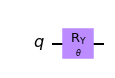

In [7]:
wavefunction = QuantumCircuit(1)
wavefunction.ry(theta, 0)
wavefunction.draw("mpl")

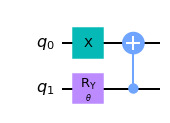

In [8]:
wavefunction2 = QuantumCircuit(2)
wavefunction2.x(0)
wavefunction2.ry(theta, 1)
wavefunction2.cx(1, 0)
wavefunction2.draw("mpl")

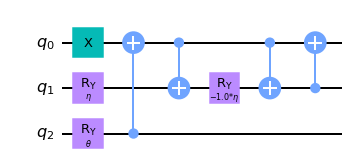

In [9]:
wavefunction3 = QuantumCircuit(3)
wavefunction3.x(0)
wavefunction3.ry(eta, 1)
wavefunction3.ry(theta, 2)
wavefunction3.cx(2, 0)
wavefunction3.cx(0, 1)
wavefunction3.ry(-eta, 1)
wavefunction3.cx(0, 1)
wavefunction3.cx(1, 0)
wavefunction3.draw("mpl")

Unfortunately, in [[1]](https://arxiv.org/pdf/1801.03897.pdf) we can't find a low-depth circuit for the ansatz for $H_4$. Then, for now we are not going to work with $N = 4$, but later we will return to this problem using `TwoLocal` as an ansatz.

Now, we can store these circuits in the ansatz list for the organization of the tests.

In [10]:
ansatz = [wavefunction, wavefunction2, wavefunction3]

The rather small size of our generated operators, allows us to use numpy functions (classical methods) to obtain the binding energy for $H_1$, $H_2$, $H_3$ and $H_4$ through the process of finding the lowest eigenvalue of the Hamiltonian matrices. This task is done in the for loop of the code cell below. 

In [11]:
reference_values = []
print("Exact binding energies calculated through numpy.linalg.eigh \n")
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    eigenvalues, eigenstates = np.linalg.eigh(hamiltonian.to_matrix())
    reference_values.append(eigenvalues[0])
    print("Exact binding energy for H_{}: {}".format(i + 1, eigenvalues[0]))

Exact binding energies calculated through numpy.linalg.eigh 

Exact binding energy for H_1: -0.43658110999999966
Exact binding energy for H_2: -1.7491598763215301
Exact binding energy for H_3: -2.045670898406441
Exact binding energy for H_4: -2.143981030799862


The results obtained above will be used as our reference values. Thus, we can use them to see if the Estimator gives us good results. In the code cell below we ran the `VQE` algorithm for each pair of `ansatz` and Hamiltonian, using the Estimator and the `SLSQP` optimizer. 

In [12]:
print(
    "Results using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper \n"
)
for i in range(3):
    seed = 42
    algorithm_globals.random_seed = seed
    vqe = VQE(Estimator(), ansatz=ansatz[i], optimizer=SLSQP())
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}: {} MeV".format(i + 1, binding_energy))

Results using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper 

Binding energy for H_1: -0.4365811096105766 MeV
Binding energy for H_2: -1.7491595316575461 MeV
Binding energy for H_3: -2.045670898257793 MeV


We can see that our results are in agreement with the reference values obtained by classical methods. We also tested some different options of optimizers provided in Qiskit, because we wanted to know which one behaves better. To do this, we make use of the `callback` option in `VQE` to allow us to store the list of counts and values. With this information it is possible to make a plot to see if the optimizer converges to the value of reference and, if it converges, how fast it does. However, in the code cell below, we are working only with the `COBYLA` optimizer for the sake of simplicity.

In [13]:
def callback(eval_count, parameters, mean, std):
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In [14]:
plots = []

for i in range(3):

    counts = []
    values = []
    params = []
    deviation = []
    seed = 42
    algorithm_globals.random_seed = seed
    vqe = VQE(Estimator(), ansatz=ansatz[i], optimizer=COBYLA(), callback=callback)
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots.append([counts, values])

'Evaluation: 45, Energy: -2.0456706360129226, Std: {}'

Plotting the results obtained with the execution of `VQE` on the previous code cell.

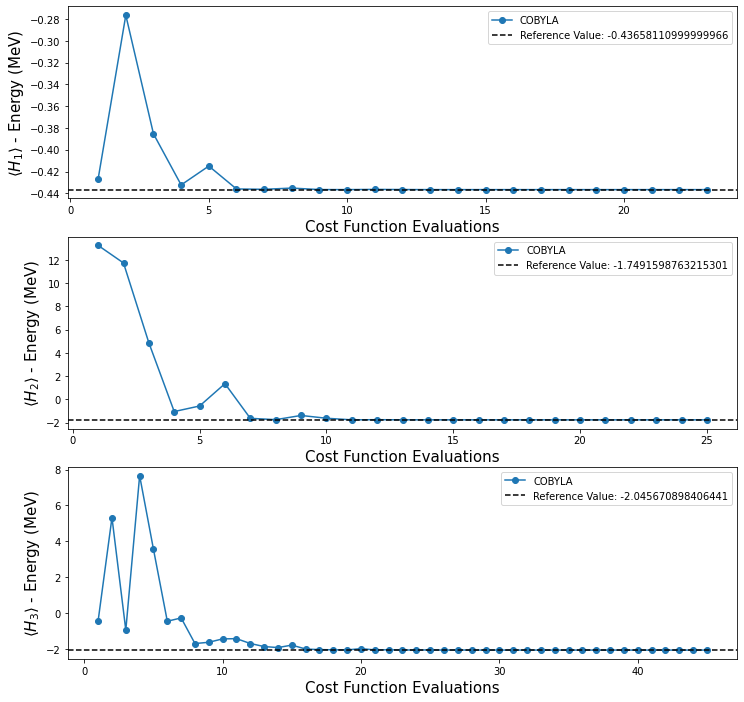

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches((12, 12))
for i, plot in enumerate(plots):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=reference_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {reference_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
plt.show()

Note that with the quantum circuits given in [[1]](https://arxiv.org/pdf/1801.03897.pdf), we can't test whether we can reach the reference value for $H_4$, because, as mentioned before, we don't have an `ansatz` for this Hamiltonian. Fortunately, that is not the end for our experiments, because Qiskit provides some functions that create an `ansatz` for us. For our purposes, we decided to use the TwoLocal function to build our new `ansatz`. In the code cell below we used a for loop to create a list with the `TwoLocal` ansatz for each Hamiltonian. 

In [16]:
twolocal_ansatzes = []
for i in range(1, 5):
    ansatz = TwoLocal(
        deuteron_hamiltonians[i - 1].num_qubits,
        ["rz", "ry"],
        "cx",
        entanglement="full",
        reps=i,
        initial_state=None,
    )
    twolocal_ansatzes.append(ansatz)

Now we can check if with this new type of `ansatz`, we can reach the reference values obtained through classical methods. To do this verification, we have to repeat the experiments done previously, but now using the `ansatz` defined through the usage of TwoLocal function.

In [17]:
print("Results using Estimator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz \n")
seed = 42
algorithm_globals.random_seed = seed
for i in range(4):
    vqe = VQE(Estimator(), ansatz=twolocal_ansatzes[i], optimizer=SLSQP())
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    binding_energy = vqe_result.optimal_value
    print("Binding energy for H_{}:".format(i + 1), binding_energy, "MeV")

Results using Estimator for H_1, H_2, H_3 and H_4 with TwoLocal ansatz 

Binding energy for H_1: -0.4365806560150798 MeV
Binding energy for H_2: -1.749159867780529 MeV
Binding energy for H_3: -2.045670867663553 MeV
Binding energy for H_4: -2.143920936644408 MeV


In [18]:
seed = 42
algorithm_globals.random_seed = seed

plots_tl = []
for i in range(4):

    counts = []
    values = []
    params = []
    deviation = []
    vqe = VQE(
        Estimator(),
        ansatz=twolocal_ansatzes[i],
        optimizer=SLSQP(),
        callback=callback,
    )
    vqe_result = vqe.compute_minimum_eigenvalue(deuteron_hamiltonians[i])
    plots_tl.append([counts, values])

'Evaluation: 4151, Energy: -2.1439209366435197, Std: {}'

Using the four different `TwoLocal` ansatze, we obtained the following results:

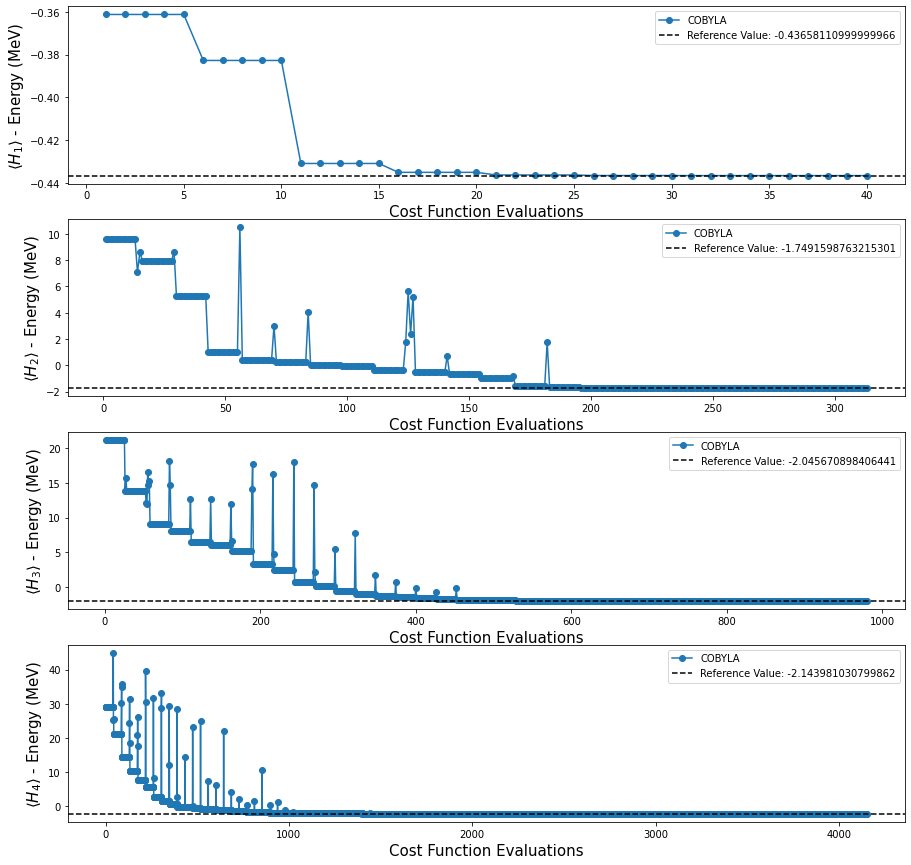

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=1)
fig.set_size_inches((15, 15))
for i, plot in enumerate(plots_tl):
    ax[i].plot(plot[0], plot[1], "o-", label="COBYLA")
    ax[i].axhline(
        y=reference_values[i],
        color="k",
        linestyle="--",
        label=f"Reference Value: {reference_values[i]}",
    )
    ax[i].legend()
    ax[i].set_xlabel("Cost Function Evaluations", fontsize=15)
    ax[i].set_ylabel(r"$\langle H_{} \rangle$ - Energy (MeV)".format(i + 1), fontsize=15)
plt.show()

## Step 4: Calculating the observables expectation values

One of our goals in the Qiskit Advocate Mentorship Program project was to show that it is possible to calculate expectation values of some observables of interest, and show how they behave when we vary a parameter in the `ansatz` circuit. In our case, the observables of interest were $I_1  \otimes Z_0$, $Z_1  \otimes I_0$, $X_1  \otimes X_0$, $Y_1  \otimes Y_0$ and $H_2$, then we investigate their behavior when the parameter $\theta$ was varied inside the interval $[-\pi,\pi]$.

In Dirac notation (bra-ket), the definition of the expectation value of an observable $\hat{O}$ is equal to [[3]](https://www.feynmanlectures.caltech.edu/III_toc.html) <a href="https://en.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)">[4]</a>:

$\langle \hat{O} \rangle_\psi = \langle \psi(\vec{\theta})|\hat{O}|\psi(\vec{\theta}) \rangle$.

The code below defines a function that calculates the expectation values of observables, given a parameterized quantum circuit and a list with some values for these parameters (angles). To build the `calculate_observables_exp_values` we use some tools of Qiskit Opflow.

In [20]:
def calculate_observables_exp_values(
    quantum_circuit: QuantumCircuit, observables: list, angles: list
) -> list:
    """Calculate the expectation value of an observable given the quantum
    circuit that represents the wavefunction and a list of parameters.

        Args:
            quantum_circuit (QuantumCircuit): A parameterized quantum circuit
            that represents the wavefunction of the system.

            observables (list): A list containing the observables that we want
            to know the expectation values.

            angles (list): A list with the values that will be used in the
            'bind_parameters' method.

        Returns:
            list_exp_values (list): A list containing the expectation values
            of the observables given as input.
    """
    list_exp_values = []
    for observable in observables:
        exp_values = []
        for angle in angles:
            qc = quantum_circuit.bind_parameters({theta: angle})
            result = estimate_observables(
                Estimator(),
                quantum_state=qc,
                observables=[observable],
            )

            exp_values.append(result[0][0])
        list_exp_values.append(exp_values)

    return list_exp_values

Calculating the expectation value of the observables of interest using the function defined above:

In [21]:
angles = list(np.linspace(-np.pi, np.pi, 100))
observables = [
    Pauli("IZ"),
    Pauli("ZI"),
    Pauli("XX"),
    Pauli("YY"),
    deuteron_hamiltonians[1],
]
h2_observables_exp_values = calculate_observables_exp_values(wavefunction2, observables, angles)

Using the function `calculate_observables_exp_values` (we defined it in the Step 2), we got the plots presented below. They showed us that we were able to reproduce the results of [[1]](https://arxiv.org/pdf/1801.03897.pdf).

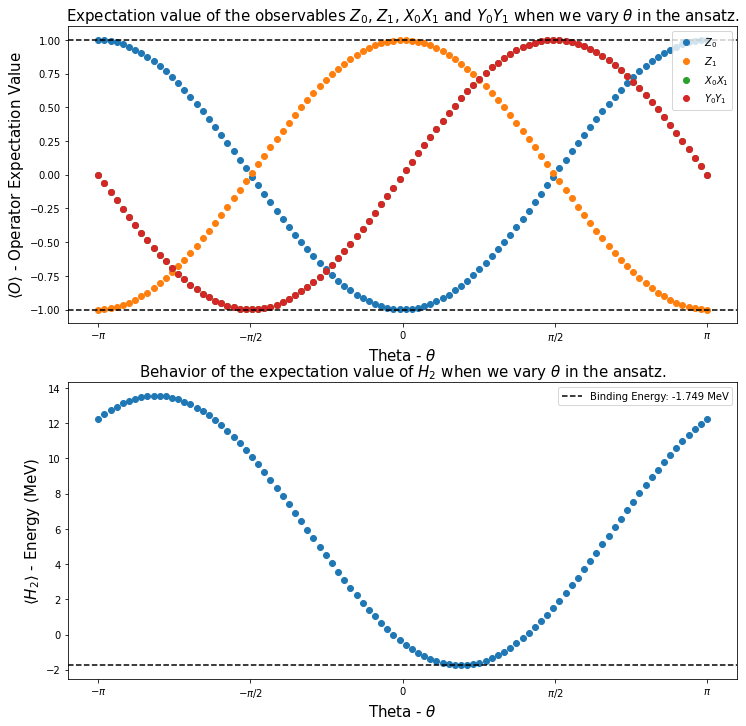

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches((12, 12))
ax[0].plot(angles, h2_observables_exp_values[0], "o", label=r"$Z_0$")
ax[0].plot(angles, h2_observables_exp_values[1], "o", label=r"$Z_1$")
ax[0].plot(angles, h2_observables_exp_values[2], "o", label=r"$X_0X_1$")
ax[0].plot(angles, h2_observables_exp_values[3], "o", label=r"$Y_0Y_1$")
ax[0].axhline(
    y=1,
    color="k",
    linestyle="--",
)
ax[0].axhline(y=-1, color="k", linestyle="--")
ax[0].legend()
ax[0].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[0].set_ylabel(r"$\langle O \rangle $ - Operator Expectation Value", fontsize=15)
ax[0].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[0].set_title(
    r"Expectation value of the observables $Z_0$, $Z_1$, $X_0X_1$ and $Y_0Y_1$ when we vary $\theta$ in the ansatz.",
    fontsize=15,
)
ax[1].plot(angles, h2_observables_exp_values[4], "o")
ax[1].axhline(
    y=reference_values[1],
    color="k",
    linestyle="--",
    label="Binding Energy: {} MeV".format(np.round(reference_values[1], 3)),
)
ax[1].legend()
ax[1].set_xlabel(r"Theta - $\theta$", fontsize=15)
ax[1].set_ylabel(r"$\langle H_2 \rangle $ - Energy (MeV)", fontsize=15)
ax[1].set_xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    labels=[r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"],
)
ax[1].set_title(
    r"Behavior of the expectation value of $H_2$ when we vary $\theta$ in the ansatz.", fontsize=15
)

plt.show()

# Acknowledgment

I would like to thank Steve Wood, Soham Pal and Siddhartha Morales for the debates in our meetings during the Qiskit Advocate Mentorship Program 2021 - Fall, they were very important for the construction of this tutorial. 

# References

[1] Dumitrescu, Eugene F., et al. "Cloud quantum computing of an atomic nucleus." Physical review letters 120.21 (2018): 210501. Arxiv version: https://arxiv.org/pdf/1801.03897.pdf

[2] Qiskit Nature Documentation. https://qiskit.org/documentation/nature/

[3] Feynman, R. P., Robert B. Leighton, and Matthew Sands. "The Feynman Lectures on Physics, Volume III: Quantum Mechanics, vol. 3." (2010). https://www.feynmanlectures.caltech.edu/III_toc.html

[4] Expectation value (quantum mechanics) Wikipedia article. https://en.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)

In [23]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright